<a href="https://colab.research.google.com/github/MelihKlc/Deep-Learning/blob/main/Transfer_learning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning with fine-tuning

In [1]:
# We use script for all helper function.
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-08 13:19:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-08 13:19:17 (83.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
 # Import helper functions we are going to use in this notebook
 from helper_functions import create_tensorboard_callback , plot_loss_curves , unzip_data , walk_through_dir

# Lets get some data

This time we are going to see how we can use the pretrained models within tf.keras.applications and then apply them to our own problem (recognizing images of food)
link : https://www.tensorflow.org/api_docs/python/tf/keras/applications


In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-08-08 13:19:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 64.233.170.128, 142.251.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.5MB/s    in 8.2s    

2023-08-08 13:19:35 (19.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
unzip_data("10_food_classes_10_percent.zip")

In [5]:
#Lets check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [6]:
# Create training and test directory path
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

#We will use different class. This class is faster than ImageDataGenerator. Yani bu sefer datagen olusturmamıza gerek olmayacak direkt bu fonksiyonun icinde halledicez hepsini.
import tensorflow as tf
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir ,
                                                                 batch_size = 32 ,
                                                                 image_size = (224,224) ,
                                                                 label_mode = "categorical"
                                                                 )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir ,
                                                                batch_size = 32 ,
                                                                image_size = (224,224) ,
                                                                label_mode = "categorical"
                                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data  #Batch dataset olarak geldi tensor. None kısmı aslında batch size. 10 classes

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out the classnames our dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images , labels in train_data.take(1): #take bizim batchimizi unravel(çözmek) etmemizi sağlıyor. Girdiğimiz 1 de 1 batch al demek
  print(images , labels)

tf.Tensor(
[[[[1.57285721e+02 1.22285713e+02 5.55714302e+01]
   [1.58260208e+02 1.24454086e+02 5.78571434e+01]
   [1.60780609e+02 1.27081635e+02 6.07755089e+01]
   ...
   [5.05714073e+01 2.55714073e+01 5.14287901e+00]
   [5.17857399e+01 2.67857399e+01 6.78574038e+00]
   [5.72296486e+01 3.02296486e+01 1.12296495e+01]]

  [[1.61000000e+02 1.29785721e+02 6.57857132e+01]
   [1.60933670e+02 1.30780609e+02 6.67142868e+01]
   [1.63142853e+02 1.33071426e+02 7.08724518e+01]
   ...
   [4.90714264e+01 2.42703876e+01 3.44394112e+00]
   [5.21479874e+01 2.71479855e+01 7.14798641e+00]
   [5.67652740e+01 3.27602730e+01 1.24286060e+01]]

  [[1.60637756e+02 1.33933670e+02 7.56428604e+01]
   [1.60000000e+02 1.34214279e+02 7.58571472e+01]
   [1.61214279e+02 1.35428558e+02 7.86428604e+01]
   ...
   [4.96428146e+01 2.72142868e+01 5.57149410e+00]
   [4.91836662e+01 2.75000134e+01 6.48470449e+00]
   [4.97857132e+01 2.94285717e+01 9.78571415e+00]]

  ...

  [[2.48030762e+02 2.04331848e+02 1.20183937e+02]
   [2

# Model 0 : Building a transfer learning feature extraction model using the Keras functional API

The sequential API is straightforward , it runs our layers in sequential order.

But the functional API gives us more flexibility with our models

In [10]:
# 1. Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top = False)  #Top layer aslında output layer oluyor biz bunu değiştireceğimiz için false yapıyoruz.

# 2. Freeze the base model ( so the underlying pre-trained patterns arent updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3) , name = "input_layer")

# 4. If using resnet50v2 you will need to normalize inputs. But in efficientnetb0 , we dont have to.
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)  eğer normalize yapmamız gerekirse böyle yapıyoruz.

# 5. Pass the inputs to the base model
x = base_model(inputs)  #base model inputlarımızı alıyor bu şekilde
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important informations , reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)  #aslında bu x i sona koydugumuzda yukarda olusturdugumuz x = basemodel kısmını buraya baglamıs oluyoruz.
print(f"Shape after GlobalAveragePooling2D : {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10 , activation = "softmax" , name = "output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs , outputs)

# 9. Compile a model

model_0.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )
# 10. Fit the model

hist_0 = model_0.fit( train_data , epochs = 5 , steps_per_epoch = len(train_data) , validation_data = test_data , validation_steps = int( 0.25 * len(test_data)) , callbacks = [create_tensorboard_callback(dir_name = "transfer_learning" , experiment_name = "10_percent_feature_extractor") ]) # test datanın %25 ini alıyoruz


16705208/16705208 [==============================] - 2s 0us/step


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D : (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extractor/20230808-131948
Epoch 1/5
24/24 [==============================] - 21s 244ms/step - loss: 1.8682 - accuracy: 0.4120 - val_loss: 1.3321 - val_accuracy: 0.7319
Epoch 2/5
24/24 [==============================] - 5s 179ms/step - loss: 1.0972 - accuracy: 0.7587 - val_loss: 0.8932 - val_accuracy: 0.8043
Epoch 3/5
24/24 [==============================] - 5s 180ms/step - loss: 0.7923 - accuracy: 0.8307 - val_loss: 0.7395 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 4s 149ms/step - loss: 0.6440 - accuracy: 0.8440 - val_loss: 0.6514 - val_accuracy: 0.8470
Epoch 5/5
24/24 [==============================] - 4s 149ms/step - loss: 0.5464 - accuracy: 0.8840 - val_loss: 0.5726 - val_accuracy: 0.8750


In [11]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 8s 92ms/step - loss: 0.5599 - accuracy: 0.8604


[0.5599428415298462, 0.8604000210762024]

In [12]:
# Check the layers our base model
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number , layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [13]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [14]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


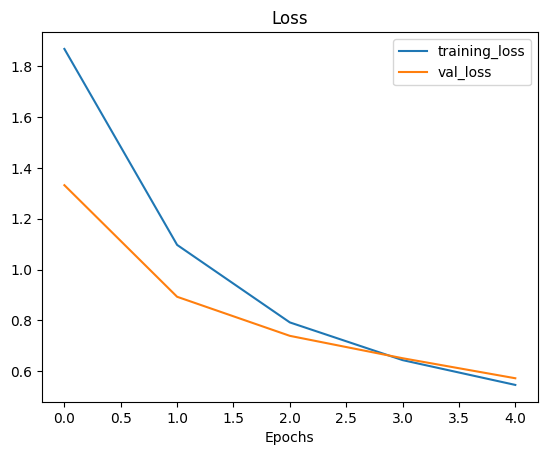

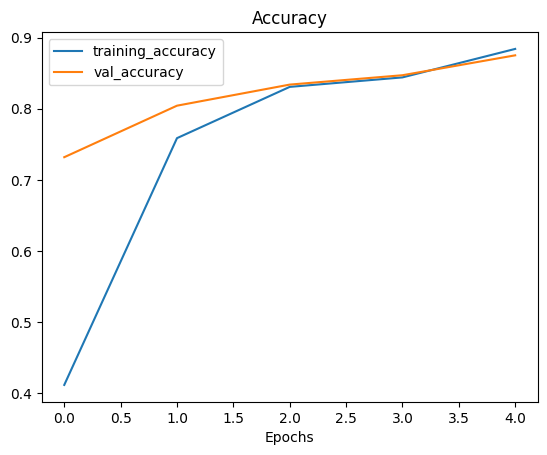

In [15]:
plot_loss_curves(hist_0)

# Getting a feature vector from a trained model   ( (None , 1280) aslında bu bizim feature vectorumuz. None kısmı batch size )

Lets get the global average pooling 2d layer

We have a tensor after our model goes through 'base_model' of shape (None , 7 , 7 , 1280).

But then , when it passes through GlobalAveragePooling2D , it turns into (None , 1280).

Lets use a similar shaped tensor of (1 , 4 , 4 , 3) and then pass it to GlobalAveragePooling2D

In [16]:
# Define the input shape
input_shape = ( 1 , 4 , 4 , 3 )
import tensorflow as tf

# Create a random tensor with input_shape
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)  #For creating random tensor
print(f"Random input tensor : \n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor : \n {global_average_pooled_tensor} \n")

# Check the shapes of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of the global average pooled tensor: {global_average_pooled_tensor.shape}")

Random input tensor : 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor : 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of the global average pooled tensor: (1, 3)


In [17]:
 # Lets replicate the GlobalAveragePool2D layer
 tf.reduce_mean(input_tensor , axis = [1,2])  # Aslında global average pooling layer bunu yapıyor. axis 1 , 2 dediğimiz ortadaki 2 dimensionun indexleri. ortadaki 2 dimension ın average ını alıp information kaybetmeden yeni 2 dimensional feature vectoru oluşturuyo

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

# One of the reasons feature extraction transfer learning is named how it is because what often happens is pre-trained model outputs a feature vector (a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case , this is the output of GlobalAveragePooling2D layer) which can then be used to extract patterns out of for our own spesific problem.  

In [18]:
# Lets do it same process with GlobalMaxPool2D

global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
global_max_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

# Feature vector aslında bizim en son outputa verdiğimiz şey. outputun inputu yani. Feature vector de pooling layer ın outputu.  Bizim bütün conv gibi layerlarımızın çıktısı büyük bir vector oluyor ve bu belli bir pattern öğrenmiş oluyor. Bu patternı condense edip en önemli bilgileri içinden alıyoruz ve küçük bir vektör haline getiriyoruz pooling layer ile.

# Running a series of transfer learning experiments

We have only seen the incredible results transfer learning can get with only %10 percent of the training data , but how does it go with %1 percent of the training data? How about we set up a bunch of experiments to find out;

1. 'model_1' - use feature extraction transfer learning with %1 percent of the training data with data augmentation.
2. 'model_2' - use feature extraction transfer learning with %10 of the training data with data augmentation.
3. 'model_3' - use fine-tuning transfer learning on %10 of the training data with data augmentation.
4. 'model_4' - use fine-tuning transfer learning on %100 of the training data with data augmentation.

> Note : throughout all experiments the same test dataset will be used to evaluate our model. this ensures consistency across evaluation metrics.

# We start with model_1

In [19]:
# Download and unzip function.
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-08-08 13:20:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 172.253.118.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  23.2MB/s    in 7.2s    

2023-08-08 13:20:52 (17.8 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create train and test directory.
train_dir_1_percent = "/content/10_food_classes_1_percent/train"
test_dir = "/content/10_food_classes_1_percent/test"


In [21]:
# How many images we are working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There a

In [22]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_1_percent ,
                                                                           batch_size = 32 ,
                                                                           image_size = (224,224) ,
                                                                           label_mode = "categorical"
                                                                           )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir ,
                                                                batch_size = 32 ,
                                                                image_size = (224,224) ,
                                                                label_mode = "categorical"
                                                                )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


# Adding data augmentation right into the model

To add data augmentation right into our models , we can use the layer inside:

> tf.keras.layers.experimental.preprocessing()

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping , rotations , zooms , etc
# Biz modelimizi oluştururken Keras API kullansak da data augmentation yaparken sequential API kullanıyoruz.

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal") ,
    preprocessing.RandomRotation(0.2) ,
    preprocessing.RandomZoom(0.2) ,
    preprocessing.RandomHeight(0.2) ,
    preprocessing.RandomWidth(0.2) ,
    #preprocessing.Rescale(1./255)  bunu resnet50v2 gibi kendi içinde rescale içermeyenlerde kullanıyoruz. Şu an efficient net kullanıyoruz ve bu modelde rescale zaten yapılmış halde oldugu icin yorum satırı olarak bırakıyoruz.

] , name = "data_augmentation")



# Off the top our of heads , the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) , happens on the GPU (much faster) , rather than CPU
* Image data augmentation only happens during training , so we can still export our whole model and use it elsewhere

(-0.5, 581.5, 586.5, -0.5)

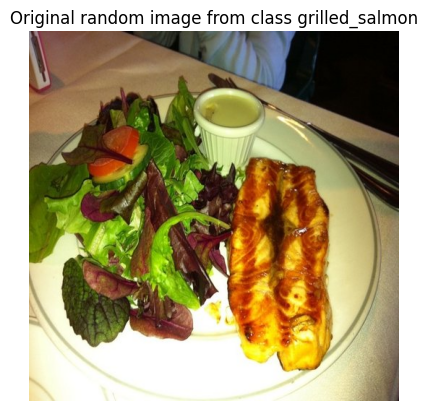

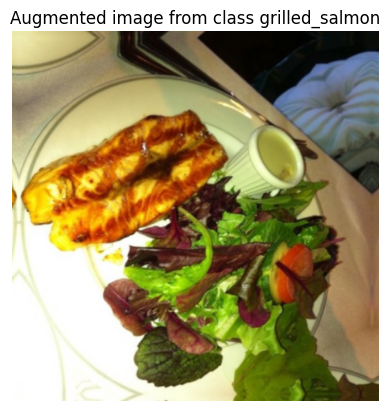

In [24]:
# View the random image and compare it with the augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))   #os.listdir(target_dir): Belirtilen dizindeki tüm dosya ve klasörlerin listesini alır. target_dir değişkeni, bu işlemi yapılacak olan dizini temsil eder.
random_image_path = target_dir + "/" + random_image

# Read and plot the random image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Plot augmented random image
augmented_image = data_augmentation(tf.expand_dims(img , axis = 0) , training = True)
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented image from class {target_class}")
plt.axis(False)



# Lets create model_1 with data augmentation

In [28]:
# Create a model_1
base_model_1 = tf.keras.applications.EfficientNetB0(include_top = False)

base_model_1.trainable = False

inputs = tf.keras.layers.Input(shape = (224,224,3) , name = "Input_layer")

# Add in data augmentation sequential model as a layer
x = data_augmentation(inputs)

# Give base_model_1 the inputs (after augmentation) and dont train it
x = base_model_1(x , training = False )

#Eğer elimizde bütün model varsa direkt içine yazıyoruz base_model_1(x  , training=False ) gibi. Eğer elimizde tek bir layer varsa x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_average_pooling_layer")(x) böyle x i en son ayrı parantezlerd yazıyoruz.

x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_average_pooling_layer")(x)

outputs = tf.keras.layers.Dense(10 , activation = "softmax" , name = "output_layer")(x)

model_1 = tf.keras.Model(inputs,outputs)

#Compile model

model_1.compile(loss = ["categorical_crossentropy"] ,
                optimizer = tf.keras.optimizers.Adam() ,
                metrics = ["accuracy"]
                )

#Fit the model

hist_1 = model_1.fit(train_data_1_percent , epochs = 5 , steps_per_epoch = len(train_data_1_percent) , validation_data = test_data , validation_steps = len(test_data))

Epoch 1/5
3/3 [==============================] - 18s 5s/step - loss: 2.3608 - accuracy: 0.0571 - val_loss: 2.2447 - val_accuracy: 0.1540
Epoch 2/5
3/3 [==============================] - 8s 4s/step - loss: 2.1469 - accuracy: 0.1857 - val_loss: 2.1089 - val_accuracy: 0.2516
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9418 - accuracy: 0.3143 - val_loss: 1.9874 - val_accuracy: 0.3496
Epoch 4/5
3/3 [==============================] - 8s 4s/step - loss: 1.7549 - accuracy: 0.5429 - val_loss: 1.8844 - val_accuracy: 0.4244
Epoch 5/5
3/3 [==============================] - 8s 4s/step - loss: 1.6232 - accuracy: 0.6143 - val_loss: 1.7927 - val_accuracy: 0.4812


In [29]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Visualize loss curve
plot_loss_curves(hist_1)